In [4]:
%pip install requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Get Images

In [2]:
import os
import shutil
import requests    

if os.path.exists("compressed_images_cuda"):
    print(f"Removing existing folder '{"compressed_images_cuda"}'…")
    shutil.rmtree("compressed_images_cuda")

os.makedirs("compressed_images_cuda", exist_ok=True)
print(f"Created folder '{"compressed_images_cuda"}'")

if os.path.exists("compressed_images_serial"):
    print(f"Removing existing folder '{"compressed_images_serial"}'…")
    shutil.rmtree("compressed_images_serial")

os.makedirs("compressed_images_serial", exist_ok=True)
print(f"Created folder '{"compressed_images_serial"}'")


if os.path.exists("cuda_results.csv"):
    os.remove("cuda_results.csv")
    print(f"Deleted {"cuda_results.csv"}")

if os.path.exists("serial_results.csv"):
    os.remove("serial_results.csv")
    print(f"Deleted {"serial_results.csv"}")

Removing existing folder 'compressed_images_cuda'…
Created folder 'compressed_images_cuda'
Removing existing folder 'compressed_images_serial'…
Created folder 'compressed_images_serial'
Deleted cuda_results.csv
Deleted serial_results.csv


In [5]:
import os
import shutil
import requests

# ─── Configuration ─────────────────────────────────────────────────────────────
GITHUB_OWNER   = 'DeveloperClyde246'         # e.g. 'octocat'
GITHUB_REPO    = 'Image-Compression-Using-DCT'             # e.g. 'my-images-repo'
GITHUB_BRANCH  = 'master'                  # e.g. 'main' or 'master'
GITHUB_PATH    = 'input_folder'        # e.g. 'assets/pics'
LOCAL_DIR      = 'images'                # Local folder name
GITHUB_TOKEN   = None                    # Or 'ghp_…' to increase rate limits

IMAGE_EXTS = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')

def download_images():
    # Step 1: Remove existing folder if present
    if os.path.exists(LOCAL_DIR):
        print(f"Removing existing folder '{LOCAL_DIR}'…")
        shutil.rmtree(LOCAL_DIR)

    # Step 2: Recreate local folder
    os.makedirs(LOCAL_DIR, exist_ok=True)
    print(f"Created folder '{LOCAL_DIR}'")

    # Step 3: Fetch directory listing from GitHub
    api_url = (
        f"https://api.github.com/repos/{GITHUB_OWNER}/{GITHUB_REPO}"
        f"/contents/{GITHUB_PATH}?ref={GITHUB_BRANCH}"
    )
    headers = {}
    if GITHUB_TOKEN:
        headers['Authorization'] = f"token {GITHUB_TOKEN}"

    resp = requests.get(api_url, headers=headers)
    resp.raise_for_status()
    items = resp.json()

    # Step 4: Download each image
    for entry in items:
        if entry.get('type') == 'file' and entry['name'].lower().endswith(IMAGE_EXTS):
            print(f"Downloading {entry['name']}…")
            img_data = requests.get(entry['download_url'], headers=headers).content
            with open(os.path.join(LOCAL_DIR, entry['name']), 'wb') as f:
                f.write(img_data)

    print("Done. All images saved in the 'images' folder.")


if __name__ == "__main__":
    download_images()

Removing existing folder 'images'…
Created folder 'images'
Done. All images saved in the 'images' folder.


# If u want to generate images of certain size

In [7]:
import os
import cv2
import shutil
import requests

# ─── Configuration ─────────────────────────────────────────────────────────────
GITHUB_OWNER   = 'DeveloperClyde246'
GITHUB_REPO    = 'Image-Compression-Using-DCT'
GITHUB_BRANCH  = 'master'
GITHUB_PATH    = 'input_folder'
LOCAL_DIR      = 'images_from_github'
GITHUB_TOKEN   = None

IMAGE_EXTS = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')
IMG_EXTS   = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.gif'}

def download_images():
    if os.path.exists(LOCAL_DIR):
        print(f"Removing existing folder '{LOCAL_DIR}'…")
        shutil.rmtree(LOCAL_DIR)

    os.makedirs(LOCAL_DIR, exist_ok=True)
    print(f"Created folder '{LOCAL_DIR}'")

    api_url = (
        f"https://api.github.com/repos/{GITHUB_OWNER}/{GITHUB_REPO}"
        f"/contents/{GITHUB_PATH}?ref={GITHUB_BRANCH}"
    )
    headers = {}
    if GITHUB_TOKEN:
        headers['Authorization'] = f"token {GITHUB_TOKEN}"

    resp = requests.get(api_url, headers=headers)
    resp.raise_for_status()
    items = resp.json()

    for entry in items:
        if entry.get('type') == 'file' and entry['name'].lower().endswith(IMAGE_EXTS):
            print(f"Downloading {entry['name']}…")
            img_data = requests.get(entry['download_url'], headers=headers).content
            with open(os.path.join(LOCAL_DIR, entry['name']), 'wb') as f:
                f.write(img_data)

    print("Done. All images saved in the 'images_from_github' folder.")

def resize_and_rename_to_jpg(input_dir, output_dir,
                             max_images=50,
                             base_size=200,
                             step_size=21):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    files = [
        f for f in os.listdir(input_dir)
        if os.path.splitext(f)[1].lower() in IMG_EXTS
    ]
    files.sort(key=lambda f: os.path.getsize(os.path.join(input_dir, f)))

    print("Files sorted by size (smallest → largest):")
    for i, fname in enumerate(files, 1):
        size = os.path.getsize(os.path.join(input_dir, fname))
        print(f"{i:2d}. {fname} — {size} bytes")
    print("-" * 40)

    for idx, fname in enumerate(files[:max_images], start=1):
        src_path = os.path.join(input_dir, fname)
        img = cv2.imread(src_path)
        if img is None:
            print(f"⚠️ Skipping unreadable file: {fname}")
            continue

        # compute dimension from user inputs
        new_dim = base_size + (idx - 1) * step_size
        resized = cv2.resize(img, (new_dim, new_dim), interpolation=cv2.INTER_AREA)

        out_name = f"image{idx}.jpg"
        out_path = os.path.join(output_dir, out_name)
        cv2.imwrite(out_path, resized, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

        print(f"{fname} → {out_name} ({new_dim} x {new_dim})")

if __name__ == "__main__":
    # ─── User inputs ────────────────────────────────────────────────────────────
    try:
        base_size = int(input("Enter starting image dimension in px (e.g. 200): "))
        step_size = int(input("Enter increment per image in px (e.g. 21): "))
        max_images = int(input("Enter max number of images to process (e.g. 50): "))
    except ValueError:
        print("Invalid input; using defaults 200, step 21, max 50.")
        base_size, step_size, max_images = 200, 21, 50

    input_folder  = LOCAL_DIR
    output_folder = "images"

    download_images()
    resize_and_rename_to_jpg(input_folder, output_folder,
                             max_images=max_images,
                             base_size=base_size,
                             step_size=step_size)


Removing existing folder 'images_from_github'…
Created folder 'images_from_github'
Done. All images saved in the 'images_from_github' folder.
Files sorted by size (smallest → largest):
 1. image2.jpg — 4352 bytes
 2. image1.jpg — 5490 bytes
 3. image5.jpg — 8473 bytes
 4. image3.jpg — 9495 bytes
 5. image10.jpg — 13157 bytes
 6. image6.jpg — 13165 bytes
 7. image4.jpg — 13516 bytes
 8. image7.jpg — 17877 bytes
 9. image11.jpg — 18294 bytes
10. image8.jpg — 19662 bytes
11. image12.jpg — 19989 bytes
12. image9.jpg — 20271 bytes
13. image13.jpg — 27764 bytes
14. image15.jpg — 35390 bytes
15. image16.jpg — 38463 bytes
16. image20.jpg — 38504 bytes
17. image17.jpg — 38886 bytes
18. image14.jpg — 42514 bytes
19. image21.jpg — 51378 bytes
20. image23.jpg — 52361 bytes
21. image24.jpg — 63139 bytes
22. image19.jpg — 65615 bytes
23. image27.jpg — 75971 bytes
24. image18.jpg — 79391 bytes
25. image22.jpg — 86138 bytes
26. image25.jpg — 105809 bytes
27. image28.jpg — 109884 bytes
28. image31.jpg 

# If u want to upload ur own image

In [8]:
%pip install ipywidgets

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 20.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import shutil
from IPython.display import display
import ipywidgets as widgets

# ─── 1) Clear (or create) the images/ folder ────────────────────────────────
IMAGES_DIR = 'images'
if os.path.exists(IMAGES_DIR):
    shutil.rmtree(IMAGES_DIR)
os.makedirs(IMAGES_DIR, exist_ok=True)
print(f"✔ Cleared and recreated folder: {IMAGES_DIR}/")

# ─── 2) Create and display the upload widget ────────────────────────────────
uploader = widgets.FileUpload(
    accept='image/*',      # only image files
    multiple=True          # allow multiple uploads
)
display(uploader)

# ─── 3) Save + rename files when uploaded ────────────────────────────────────
def _save_and_rename(change):
    # Gather uploaded file-info dicts
    files = list(uploader.value)  
    # Sort by size of bytes content
    files_sorted = sorted(files, key=lambda f: len(f['content']))
    for idx, file_info in enumerate(files_sorted, start=1):
        original_name = file_info['name']                  # e.g. "photo.PNG"
        content       = file_info['content']               # raw bytes
        # Extract extension and normalize to lower-case
        _, ext = os.path.splitext(original_name)
        ext = ext.lower() if ext else '.jpg'
        # Build new filename: image1.jpg, image2.png, etc.
        new_name = f"image{idx}{ext}"
        out_path = os.path.join(IMAGES_DIR, new_name)
        # Write file
        with open(out_path, 'wb') as f:
            f.write(content)
        print(f"Saved {original_name} → {new_name} ({len(content)} bytes)")
    print(f"✅ Total: {len(files_sorted)} image(s) saved in '{IMAGES_DIR}/'")

# Trigger on new uploads
uploader.observe(_save_and_rename, names='value')


✔ Cleared and recreated folder: images/


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

# Plot Graph

In [5]:
%pip install pandas
%pip install matplotlib

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------------- -------------------------- 3.9/11.5 MB 22.5 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.5 MB 17.6 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.5 MB 11.3 MB/s eta 0:00:01
   ------------------------------- -------- 8.9/11.5 MB 11.6 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.5 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ----------- ---------------------------- 3.7/12.6 MB 18.0 MB/s eta 0:00:01
   ------------------------- -------------- 8.1/12.6 MB 19.9 MB/s eta 0:00:01
   -------------------------------------- - 12.3/12.6 MB 20.3 MB/s eta 0:00:01
   ---------------------------------------- 12.6/12.6 MB 19.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------ --------------------- 3.7/8.1 MB 18.1 MB/s eta 0:00:01
   ------------------------------------- -- 7.6/8.1 MB 18.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 17.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 17.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 23.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


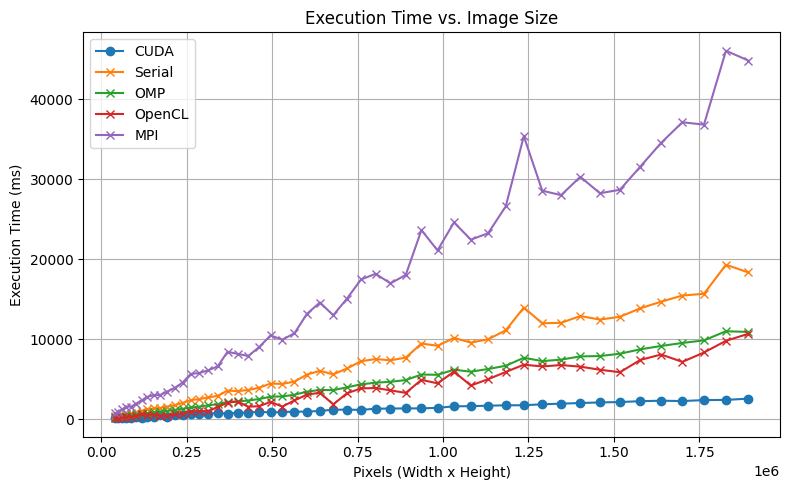

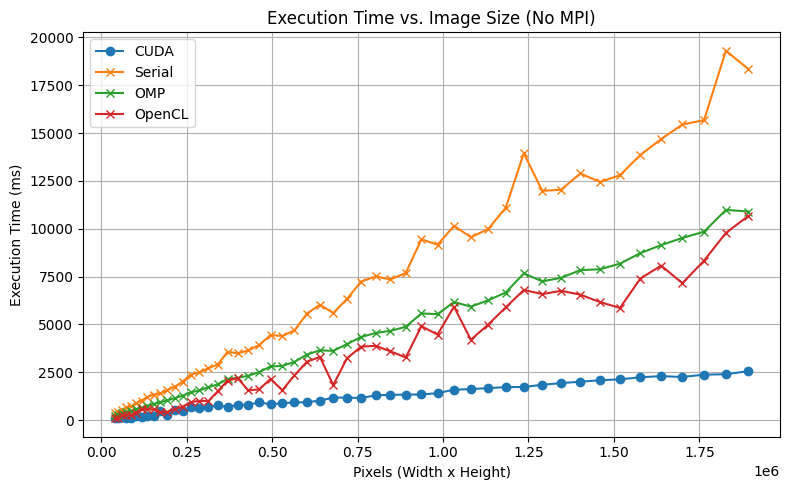

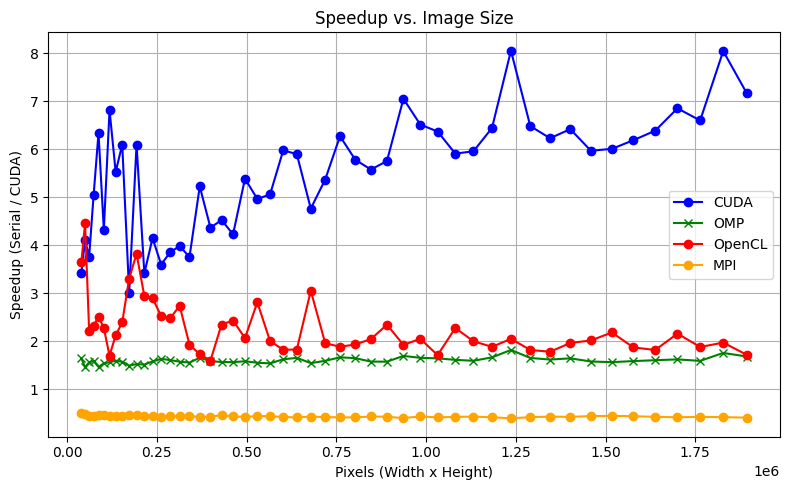

In [ ]:
import csv
import matplotlib.pyplot as plt

def load_data(path):
    """
    Load Pixels and Time_ms columns from a CSV into two lists.
    Assumes the CSV has headers 'Pixels' and 'Time_ms'.
    """
    pixels = []
    times = []
    with open(path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            pixels.append(int(row['Pixels']))
            times.append(float(row['Time_ms']))
    return pixels, times

# 1) Load data
cuda_pixels, cuda_times     = load_data('cuda_results.csv')
serial_pixels, serial_times = load_data('serial_results.csv')
omp_pixels, omp_times = load_data("openmp_results.csv")
opencl_pixels, opencl_times = load_data("opencl_results.csv")
mpi_pixels, mpi_times = load_data("mpi_results.csv")

# 2) Plot Execution Time vs Image Size
plt.figure(figsize=(8,5))
plt.plot(cuda_pixels, cuda_times,   marker='o', label='CUDA')
plt.plot(serial_pixels, serial_times, marker='x', label='Serial')
plt.plot(omp_pixels, omp_times, marker='x', label='OMP')
plt.plot(opencl_pixels, opencl_times, marker='x', label='OpenCL')
plt.plot(mpi_pixels, mpi_times, marker='x', label='MPI')
plt.xlabel('Pixels (Width x Height)')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time vs. Image Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 2) Plot Execution Time vs Image Size
plt.figure(figsize=(8,5))
plt.plot(cuda_pixels, cuda_times,   marker='o', label='CUDA')
plt.plot(serial_pixels, serial_times, marker='x', label='Serial')
plt.plot(omp_pixels, omp_times, marker='x', label='OMP')
plt.plot(opencl_pixels, opencl_times, marker='x', label='OpenCL')
# plt.plot(mpi_pixels, mpi_times, marker='x', label='MPI')
plt.xlabel('Pixels (Width x Height)')
plt.ylabel('Execution Time (ms)')
plt.title('Execution Time vs. Image Size (No MPI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Compute and Plot Speedup = serial_time / cuda_time
#    Assumes both lists are sorted in the same order of pixel counts
cuda_speedup = [s / c for s, c in zip(serial_times, cuda_times)]
omp_speedup = [s / c for s, c in zip(serial_times, omp_times)]
opencl_speedup = [s / c for s, c in zip(serial_times, opencl_times)]
mpi_speedup = [s / c for s, c in zip(serial_times, mpi_times)]

plt.figure(figsize=(8,5))
plt.plot(cuda_pixels, cuda_speedup, marker='o', color='blue', label='CUDA')
plt.plot(omp_pixels, omp_speedup, marker='x', color='green', label='OMP')
plt.plot(opencl_pixels, opencl_speedup, marker='o', color='red', label='OpenCL')
plt.plot(mpi_pixels, mpi_speedup, marker='o', color='orange', label='MPI')
plt.xlabel('Pixels (Width x Height)')
plt.ylabel('Speedup (Serial / CUDA)')
plt.title('Speedup vs. Image Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
